In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar

In [20]:
df = pd.read_csv("mock_intuit_2year_data.csv")

In [21]:
df.columns

Index(['Date', 'Arrival time', 'Start time', 'End time', 'Customer ID',
       'Expert ID', 'Answered?', 'Communication channel', 'Product group',
       'Skill certifications', 'Avg handle time by expert',
       'Resolution Rate By expert', 'Transfer Rate by expert',
       'Satisfaction score given from customers',
       'Customer History / Contact history',
       'Self service attempts before calling', 'Session ID / Contact ID',
       'Expert assigned', 'Resolution outcome', 'Transfer destination',
       'Number of transfers in session', 'Post resolution behavior',
       'Transfer Flag', 'First Call Resolution', 'Hold time during call',
       'DURATION OF CALL', 'OCCUPANCY'],
      dtype='object')

## Data Cleaning

In [22]:
# 1. Load Data
df = pd.read_csv('mock_intuit_2year_data.csv')

# 2. Convert to Datetime and Sort
df['Arrival time'] = pd.to_datetime(df['Arrival time'])
df = df.sort_values('Arrival time')

# 3. Aggregate to 30-minute intervals
# We set the index to Arrival Time and resample
df_agg = df.set_index('Arrival time').resample('30min').size().to_frame('Call_Volume')

# 4. Fill gaps (crucial for 24/7 consistency)
# This ensures even 3 AM on a Sunday exists in the data, even if volume is 0
df_agg = df_agg.asfreq('30min', fill_value=0)

print(f"Total 30-min intervals: {len(df_agg)}")

Total 30-min intervals: 35034


In [23]:
# 2. Enhanced Feature Engineering (Now with Holidays)
# ---------------------------------------------------------
def create_features(data):
    df = data.copy()
    
    # --- NEW: Holiday Feature ---
    cal = USFederalHolidayCalendar()
    # Get all holidays within the range of your dataset
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    
    # check if the date (normalized to midnight) is in the holiday list
    # .astype(int) converts True/False to 1/0 for the model
    df['is_holiday'] = df.index.normalize().isin(holidays).astype(int)
    
    # --- Time Features ---
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    
    # --- Cyclical Encoding (Crucial for time consistency) ---
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # --- Lag Features (Horizon Safe > 4 weeks) ---
    # We stick to the "Planning Horizon" rule: only use data from >28 days ago
    df['lag_4weeks'] = df['Call_Volume'].shift(48 * 28)
    df['trend_4w'] = df['Call_Volume'].shift(48 * 28).rolling(window=48*7).mean()

    return df

# Apply features and drop initial NaNs
df_features = create_features(df_agg)
df_features = df_features.dropna()

In [26]:
# 3. Train / Test Split
# ---------------------------------------------------------
split_date = '2025-01-01'
train = df_features.loc[df_features.index < split_date]
test = df_features.loc[df_features.index >= split_date]

# We add 'is_holiday' to our list of features
features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
            'month', 'is_holiday', 'lag_4weeks', 'trend_4w']
target = 'Call_Volume'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print(f"Training on {X_train.shape[0]} intervals")
print(f"Testing on {X_test.shape[0]} intervals")

Training on 15884 intervals
Testing on 17471 intervals


In [31]:
# 3. Define the Search Space
# ---------------------------------------------------------
# These are the "knobs" we can turn to improve the model
param_grid = {
    'n_estimators': [500, 1000, 1500],        # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],       # How fast the model learns
    'max_depth': [3, 5, 7, 9],                # How complex each tree can be
    'min_child_weight': [1, 3, 5],            # Controls overfitting (higher = more conservative)
    'subsample': [0.7, 0.8, 0.9, 1.0],        # Fraction of data used per tree
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]  # Fraction of features used per tree
}

# 4. Run Randomized Search
# ---------------------------------------------------------
# TimeSeriesSplit ensures we don't cheat by looking at the future
tscv = TimeSeriesSplit(n_splits=3)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,               # Tries 20 random combinations (increase for better results)
    scoring='neg_mean_absolute_error', # optimizes for MAE
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting Hyperparameter Tuning...")
random_search.fit(X_train, y_train)

# 5. Evaluate Best Model
# ---------------------------------------------------------
print(f"\nBest Parameters Found: {random_search.best_params_}")

best_model = random_search.best_estimator_
test['prediction'] = best_model.predict(X_test)

mae = mean_absolute_error(test['Call_Volume'], test['prediction'])
rmse = np.sqrt(mean_squared_error(test['Call_Volume'], test['prediction']))

print(f"New MAE: {mae:.2f}")
print(f"New RMSE: {rmse:.2f}")

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters Found: {'subsample': 1.0, 'n_estimators': 1500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
New MAE: 1.11
New RMSE: 1.98


C:\Users\sarah\AppData\Local\Temp\ipykernel_19688\2732379679.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = best_model.predict(X_test)


In [37]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from pandas.tseries.holiday import USFederalHolidayCalendar

# 1. Load & Preprocess
# ---------------------------------------------------------
df = pd.read_csv('mock_intuit_2year_data.csv')
df['Arrival time'] = pd.to_datetime(df['Arrival time'])
df = df.sort_values('Arrival time')

# Aggregate to 30-min
df_agg = df.set_index('Arrival time').resample('30min').size().to_frame('Call_Volume')
df_agg = df_agg.asfreq('30min', fill_value=0)

# 2. Feature Engineering
# ---------------------------------------------------------
def create_features(data):
    df = data.copy()
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    df['is_holiday'] = df.index.normalize().isin(holidays).astype(int)
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    df['lag_4weeks'] = df['Call_Volume'].shift(48 * 28)
    df['trend_4w'] = df['Call_Volume'].shift(48 * 28).rolling(window=48*7).mean()
    
    return df

df_features = create_features(df_agg).dropna()

# 3. Split Data
# ---------------------------------------------------------
split_date = '2025-01-01'
train = df_features.loc[df_features.index < split_date]
# We don't strictly need 'test' for the search, but good to have context

features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
            'month', 'is_holiday', 'lag_4weeks', 'trend_4w']
target = 'Call_Volume'

X_train = train[features]
y_train = train[target]

# 4. Define Search Grid
# ---------------------------------------------------------
# Random Forest Parameters:
# n_estimators: More is better, but slower.
# max_depth: Controls complexity. Too high = overfitting.
# min_samples_split: How many samples needed to split a node.
# min_samples_leaf: How many samples needed in a final leaf (Crucial for smoothing).
# max_features: 'sqrt' is standard, but 'None' (using all features) can sometimes work better for small feature sets.

param_grid = {
    'n_estimators': [200, 500, 800],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None] 
}

# 5. Run Search
# ---------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=3)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  # Number of random combinations to try
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting Hyperparameter Tuning for Random Forest...")
random_search.fit(X_train, y_train)

# 6. Output Best Params
# ---------------------------------------------------------
print("\nBest Parameters Found:")
print(random_search.best_params_)
print(f"\nBest CV Score (MAE): {-random_search.best_score_:.4f}")

Starting Hyperparameter Tuning for Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters Found:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 25}

Best CV Score (MAE): 1.3571


Overall MAE: 0.98
January MAE: 1.80
Post-Tax Drop (Apr 16 - May 15) MAE: 0.88


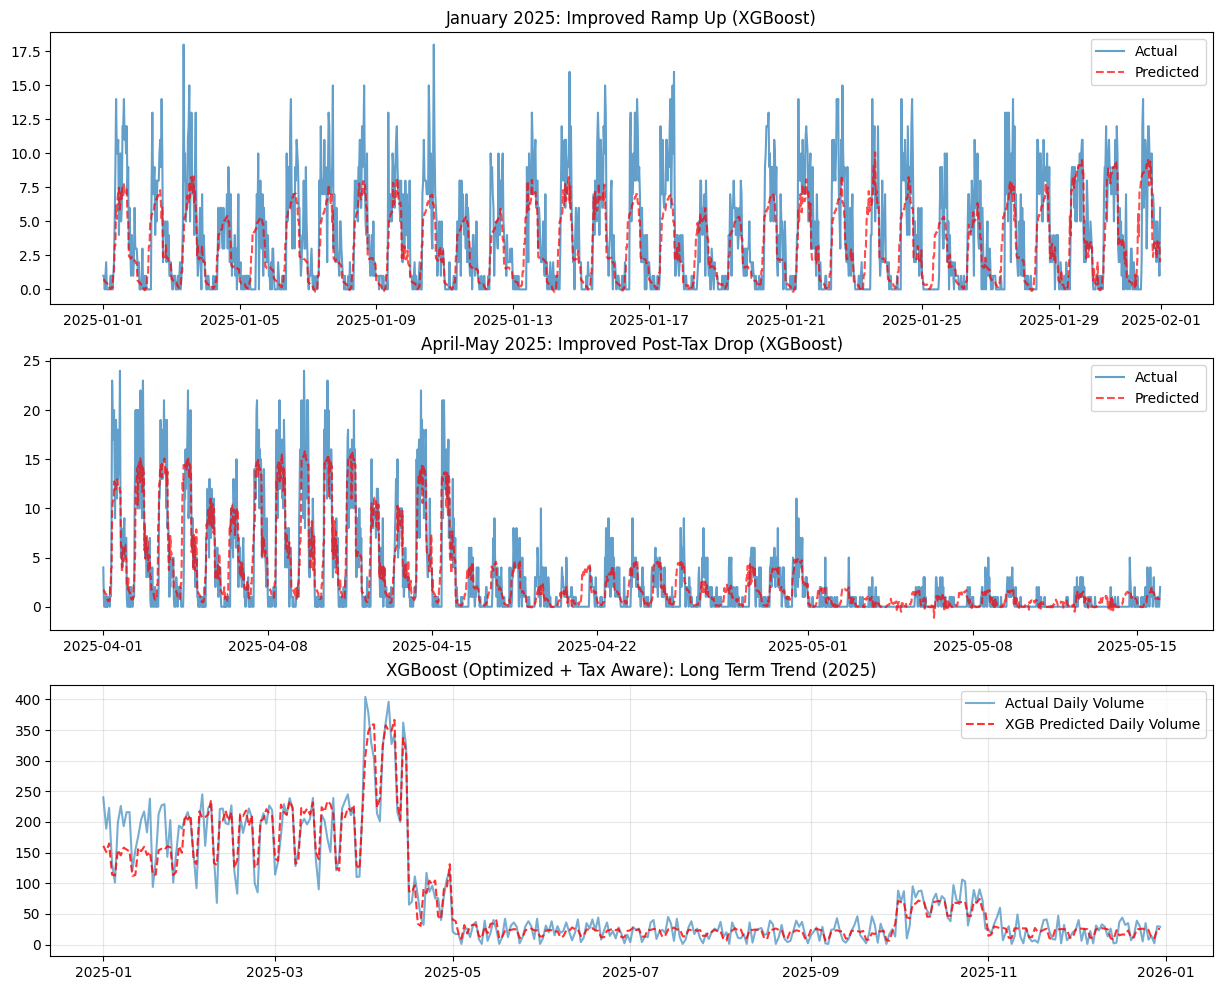

In [41]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar

# 1. Load Data
# ---------------------------------------------------------
df = pd.read_csv('mock_intuit_2year_data.csv')
df['Arrival time'] = pd.to_datetime(df['Arrival time'])
df = df.sort_values('Arrival time')

# Aggregate
df_agg = df.set_index('Arrival time').resample('30min').size().to_frame('Call_Volume')
df_agg = df_agg.asfreq('30min', fill_value=0)

# 2. Enhanced Feature Engineering (Tax Aware)
# ---------------------------------------------------------
def create_features(data):
    df = data.copy()
    
    # --- Standard Time Features ---
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    df['is_holiday'] = df.index.normalize().isin(holidays).astype(int)
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    
    # Cyclical Encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # --- NEW: Tax Season Specifics ---
    # 1. Calculate "Tax Day" for the current year (April 15)
    tax_days = pd.to_datetime(df.index.year.astype(str) + '-04-15')
    
    # 2. Days Until Tax Day (Countdown)
    df['days_to_tax_day'] = (tax_days - df.index.normalize()).days
    
    # 3. Explicit Flags
    df['is_tax_season'] = ((df['month'] <= 4) & (df['days_to_tax_day'] >= 0)).astype(int)
    
    # 4. The "Post-April 15" Drop Flag (April 16 to May 15)
    df['is_post_tax_drop'] = ((df['days_to_tax_day'] < 0) & (df['days_to_tax_day'] > -31)).astype(int)

    # --- Lags ---
    df['lag_4weeks'] = df['Call_Volume'].shift(48 * 28)
    df['trend_4w'] = df['Call_Volume'].shift(48 * 28).rolling(window=48*7).mean()
    
    return df

df_features = create_features(df_agg).dropna()

# 3. Split & Train
# ---------------------------------------------------------
split_date = '2025-01-01'
train = df_features.loc[df_features.index < split_date]
test = df_features.loc[df_features.index >= split_date].copy()

features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
            'month', 'is_holiday', 'lag_4weeks', 'trend_4w',
            'days_to_tax_day', 'is_tax_season', 'is_post_tax_drop']

# Using Optimized Parameters found in previous steps
reg = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=3,
    subsample=1.0,
    colsample_bytree=0.7,
    objective='reg:squarederror'
)

reg.fit(train[features], train['Call_Volume'])

# 4. Evaluate
# ---------------------------------------------------------
test['prediction'] = reg.predict(test[features])

print(f"Overall MAE: {mean_absolute_error(test['Call_Volume'], test['prediction']):.2f}")

# Check specific periods
jan_error = mean_absolute_error(
    test.loc['2025-01-01':'2025-01-31', 'Call_Volume'], 
    test.loc['2025-01-01':'2025-01-31', 'prediction']
)
post_tax_error = mean_absolute_error(
    test.loc['2025-04-16':'2025-05-15', 'Call_Volume'], 
    test.loc['2025-04-16':'2025-05-15', 'prediction']
)

print(f"January MAE: {jan_error:.2f}")
print(f"Post-Tax Drop (Apr 16 - May 15) MAE: {post_tax_error:.2f}")

# 5. Plot
f, ax = plt.subplots(3, 1, figsize=(15, 12))

# Plot Jan
jan_slice = test.loc['2025-01-01':'2025-01-31']
ax[0].plot(jan_slice.index, jan_slice['Call_Volume'], label='Actual', alpha=0.7)
ax[0].plot(jan_slice.index, jan_slice['prediction'], label='Predicted', alpha=0.7, linestyle='--', color='red')
ax[0].set_title('January 2025: Improved Ramp Up (XGBoost)')
ax[0].legend()

# Plot Apr-May
apr_may_slice = test.loc['2025-04-01':'2025-05-15']
ax[1].plot(apr_may_slice.index, apr_may_slice['Call_Volume'], label='Actual', alpha=0.7)
ax[1].plot(apr_may_slice.index, apr_may_slice['prediction'], label='Predicted', alpha=0.7, linestyle='--', color='red')
ax[1].set_title('April-May 2025: Improved Post-Tax Drop (XGBoost)')
ax[1].legend()

# Plot Long Term
daily_actual = test['Call_Volume'].resample('D').sum()
daily_pred = test['prediction'].resample('D').sum()

ax[2].plot(daily_actual.index, daily_actual, label='Actual Daily Volume', alpha=0.6)
ax[2].plot(daily_pred.index, daily_pred, label='XGB Predicted Daily Volume', alpha=0.8, linestyle='--', color='red')
ax[2].set_title('XGBoost (Optimized + Tax Aware): Long Term Trend (2025)')
ax[2].legend()
ax[2].grid(True, alpha=0.3)

plt.show()

Overall MAE: 0.97
January MAE: 1.83
Post-Tax Drop (Apr 16 - May 15) MAE: 0.90


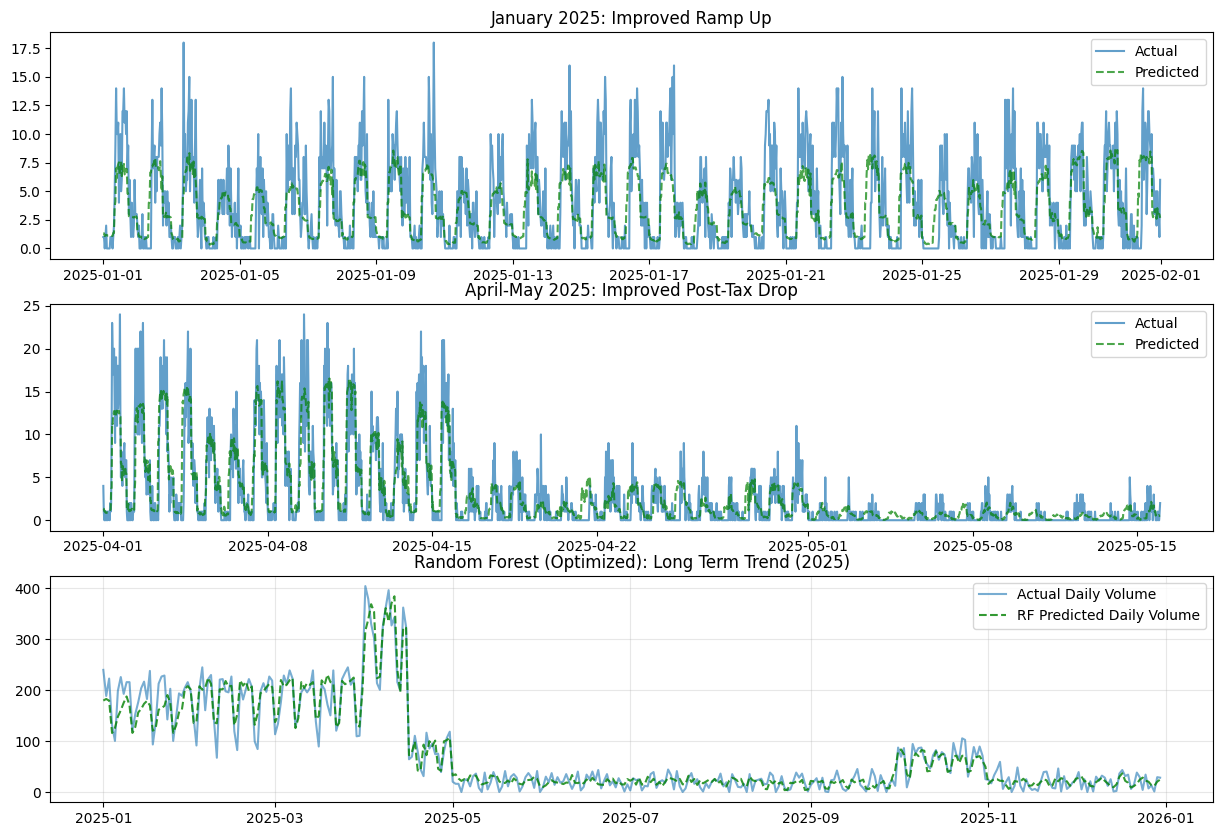

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from pandas.tseries.holiday import USFederalHolidayCalendar

# 1. Load Data
# ---------------------------------------------------------
df = pd.read_csv('mock_intuit_2year_data.csv')
df['Arrival time'] = pd.to_datetime(df['Arrival time'])
df = df.sort_values('Arrival time')

# Aggregate
df_agg = df.set_index('Arrival time').resample('30min').size().to_frame('Call_Volume')
df_agg = df_agg.asfreq('30min', fill_value=0)

# 2. Enhanced Feature Engineering
# ---------------------------------------------------------
def create_features(data):
    df = data.copy()
    
    # --- Standard Time Features ---
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    df['is_holiday'] = df.index.normalize().isin(holidays).astype(int)
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    
    # Cyclical Encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # --- NEW: Tax Season Specifics ---
    # 1. Calculate "Tax Day" for the current year (April 15)
    tax_days = pd.to_datetime(df.index.year.astype(str) + '-04-15')
    
    # 2. Days Until Tax Day (Countdown)
    # This is powerful: It's +100 in Jan, 0 on Tax Day, and -15 in May.
    # The model learns: "As this number gets closer to 0, Volume goes UP."
    # "As soon as this number turns negative, Volume crashes."
    df['days_to_tax_day'] = (tax_days - df.index.normalize()).days
    
    # 3. Explicit Flags (Helps Tree models split easier)
    df['is_tax_season'] = ((df['month'] <= 4) & (df['days_to_tax_day'] >= 0)).astype(int)
    
    # 4. The "Post-April 15" Drop Flag (April 16 to May 15)
    # This specifically addresses your observation of overestimation in late April.
    df['is_post_tax_drop'] = ((df['days_to_tax_day'] < 0) & (df['days_to_tax_day'] > -31)).astype(int)

    # --- Lags ---
    df['lag_4weeks'] = df['Call_Volume'].shift(48 * 28)
    df['trend_4w'] = df['Call_Volume'].shift(48 * 28).rolling(window=48*7).mean()
    
    return df

df_features = create_features(df_agg).dropna()

# 3. Split & Train
# ---------------------------------------------------------
split_date = '2025-01-01'
train = df_features.loc[df_features.index < split_date]
test = df_features.loc[df_features.index >= split_date].copy()

features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
            'month', 'is_holiday', 'lag_4weeks', 'trend_4w',
            'days_to_tax_day', 'is_tax_season', 'is_post_tax_drop'] # New features included

rf_reg = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=25,
    n_jobs=-1,
    random_state=42
)

rf_reg.fit(train[features], train['Call_Volume'])

# 4. Evaluate
# ---------------------------------------------------------
test['prediction'] = rf_reg.predict(test[features])

print(f"Overall MAE: {mean_absolute_error(test['Call_Volume'], test['prediction']):.2f}")

# Check the specific periods you were worried about
jan_error = mean_absolute_error(
    test.loc['2025-01-01':'2025-01-31', 'Call_Volume'], 
    test.loc['2025-01-01':'2025-01-31', 'prediction']
)
post_tax_error = mean_absolute_error(
    test.loc['2025-04-16':'2025-05-15', 'Call_Volume'], 
    test.loc['2025-04-16':'2025-05-15', 'prediction']
)

print(f"January MAE: {jan_error:.2f}")
print(f"Post-Tax Drop (Apr 16 - May 15) MAE: {post_tax_error:.2f}")

# 5. Plot the Fix
f, ax = plt.subplots(3, 1, figsize=(15, 10))

# Plot Jan
jan_slice = test.loc['2025-01-01':'2025-01-31']
ax[0].plot(jan_slice.index, jan_slice['Call_Volume'], label='Actual', alpha=0.7)
ax[0].plot(jan_slice.index, jan_slice['prediction'], label='Predicted', alpha=0.7, linestyle='--', color='green')
ax[0].set_title('January 2025: Improved Ramp Up')
ax[0].legend()

# Plot Apr-May
apr_may_slice = test.loc['2025-04-01':'2025-05-15']
ax[1].plot(apr_may_slice.index, apr_may_slice['Call_Volume'], label='Actual', alpha=0.7)
ax[1].plot(apr_may_slice.index, apr_may_slice['prediction'], label='Predicted', alpha=0.7, linestyle='--', color='green')
ax[1].set_title('April-May 2025: Improved Post-Tax Drop')
ax[1].legend()

# Plot 3: Long Term Trend
daily_actual = test['Call_Volume'].resample('D').sum()
daily_pred = test['prediction'].resample('D').sum()

ax[2].plot(daily_actual.index, daily_actual, label='Actual Daily Volume', alpha=0.6)
ax[2].plot(daily_pred.index, daily_pred, label='RF Predicted Daily Volume', alpha=0.8, linestyle='--', color='green')
ax[2].set_title('Random Forest (Optimized): Long Term Trend (2025)')
ax[2].legend()
ax[2].grid(True, alpha=0.3)

plt.show()

Training Random Forest...
Training Gradient Boosting (XGBoost Proxy)...

--- Results ---
Random Forest MAE: 0.994
XGBoost MAE:       1.001
STACKED MAE:       0.978  <-- WINNER


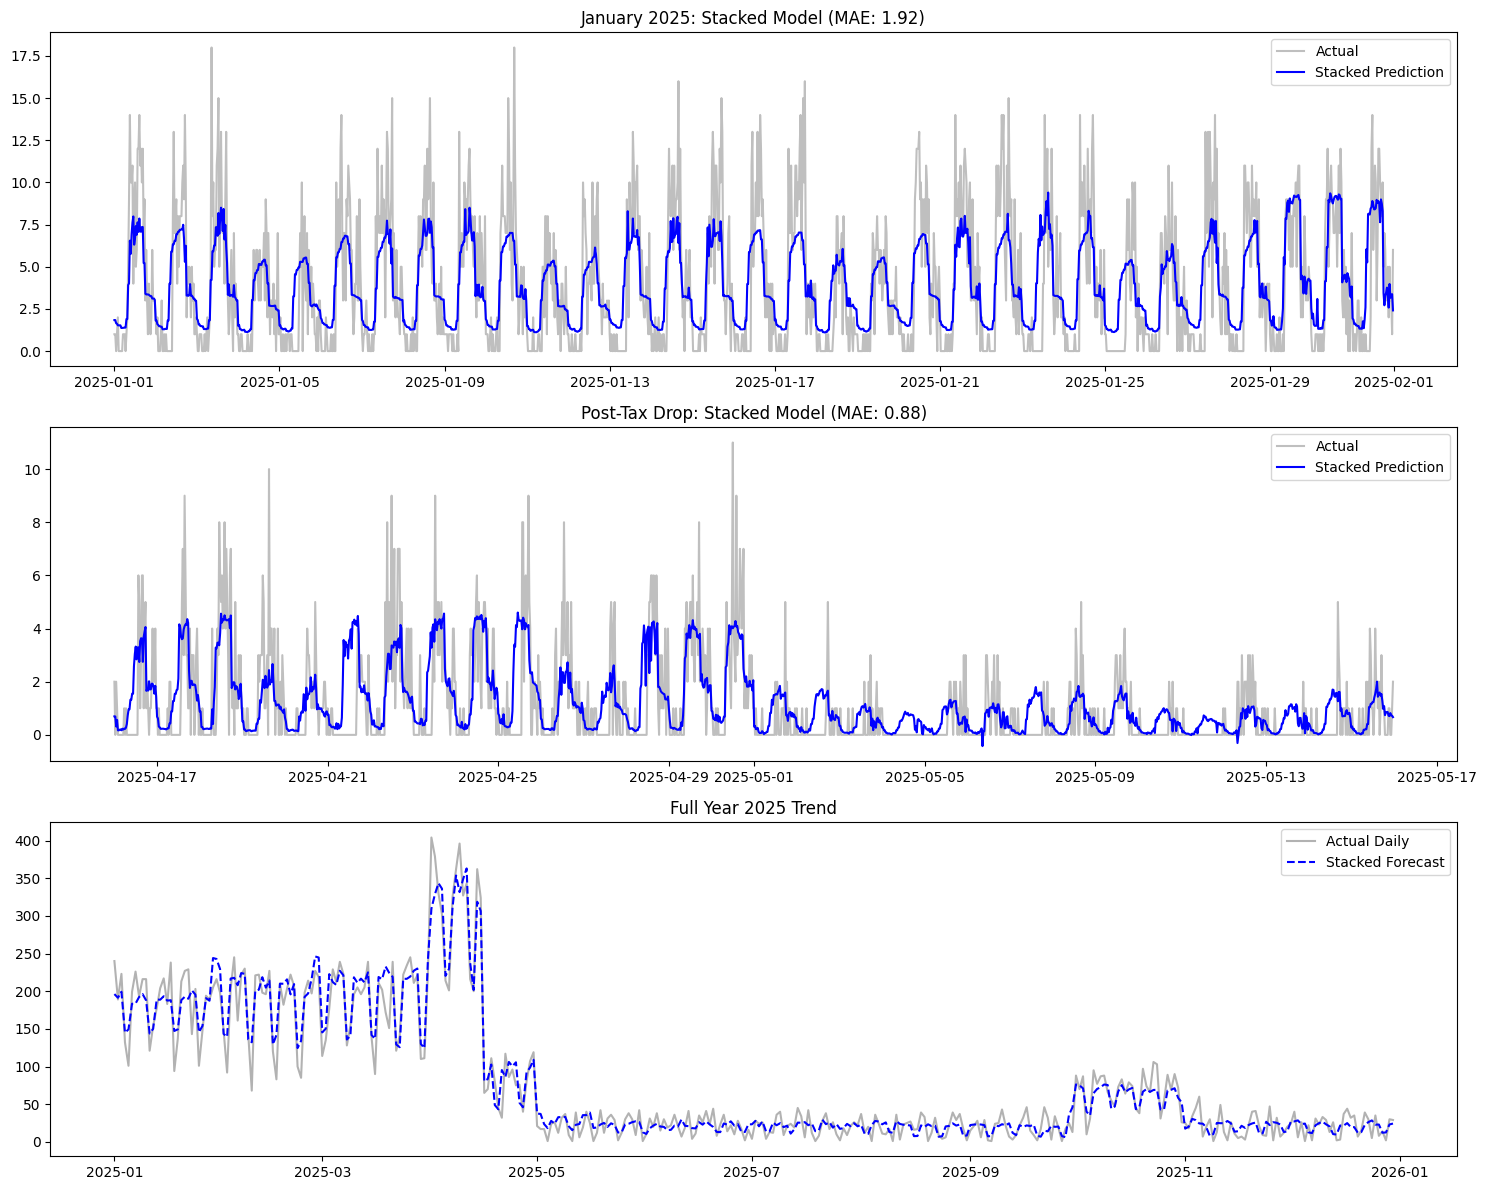

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar

# ==========================================
# 1. LOAD & AGGREGATE
# ==========================================
df = pd.read_csv('mock_intuit_2year_data.csv')
df['Arrival time'] = pd.to_datetime(df['Arrival time'])
df = df.sort_values('Arrival time')

# Aggregate to 30-min
df_agg = df.set_index('Arrival time').resample('30min').size().to_frame('Call_Volume')
df_agg = df_agg.asfreq('30min', fill_value=0)

# ==========================================
# 2. UNIFIED FEATURE ENGINEERING
# ==========================================
def create_features(data):
    df = data.copy()
    
    # --- A. Time & Calendar ---
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    df['is_holiday'] = df.index.normalize().isin(holidays).astype(int)
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    df['is_january'] = (df['month'] == 1).astype(int)
    
    # Cyclical Encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # --- B. Tax Season Logic ---
    tax_days = pd.to_datetime(df.index.year.astype(str) + '-04-15')
    df['days_to_tax_day'] = (tax_days - df.index.normalize()).days
    df['is_tax_season'] = ((df['month'] <= 4) & (df['days_to_tax_day'] >= 0)).astype(int)
    df['is_post_tax_drop'] = ((df['days_to_tax_day'] < 0) & (df['days_to_tax_day'] > -31)).astype(int)

    # --- C. Lags & Peaks ---
    # 4 weeks = 28 days = 1344 intervals of 30 mins
    df['lag_4weeks'] = df['Call_Volume'].shift(48 * 28)
    df['trend_4w'] = df['Call_Volume'].shift(48 * 28).rolling(window=48*7).mean()
    df['max_4w'] = df['Call_Volume'].shift(48 * 28).rolling(window=48*7).max()
    
    return df

df_features = create_features(df_agg).dropna()

# ==========================================
# 3. SPLIT DATA
# ==========================================
split_date = '2025-01-01'
train = df_features.loc[df_features.index < split_date]
test = df_features.loc[df_features.index >= split_date].copy()

features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
            'month', 'weekofyear', 'is_january', 'is_holiday',
            'days_to_tax_day', 'is_tax_season', 'is_post_tax_drop',
            'lag_4weeks', 'trend_4w', 'max_4w']
target = 'Call_Volume'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# ==========================================
# 4. TRAIN MODELS
# ==========================================

# --- Model A: Random Forest (Good at finding cutoffs/rules) ---
rf_model = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=25,
    n_jobs=-1,
    random_state=42
)
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# --- Model B: XGBoost (Good at gradients/trends) ---
# Note: Using GradientBoostingRegressor as proxy if XGBoost lib not available
xgb_model = GradientBoostingRegressor(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=3,
    min_samples_leaf=3,
    max_features=0.7,
    subsample=1.0,
    random_state=42
)
print("Training Gradient Boosting (XGBoost Proxy)...")
xgb_model.fit(X_train, y_train)

# ==========================================
# 5. STACKING (The Magic)
# ==========================================
test['pred_rf'] = rf_model.predict(X_test)
test['pred_xgb'] = xgb_model.predict(X_test)

# Simple Average Stacking
# (You can change weights to 0.6*pred_rf + 0.4*pred_xgb if one is clearly better)
test['pred_stacked'] = (test['pred_rf'] + test['pred_xgb']) / 2

# ==========================================
# 6. EVALUATE
# ==========================================
mae_rf = mean_absolute_error(test['Call_Volume'], test['pred_rf'])
mae_xgb = mean_absolute_error(test['Call_Volume'], test['pred_xgb'])
mae_stack = mean_absolute_error(test['Call_Volume'], test['pred_stacked'])

print(f"\n--- Results ---")
print(f"Random Forest MAE: {mae_rf:.3f}")
print(f"XGBoost MAE:       {mae_xgb:.3f}")
print(f"STACKED MAE:       {mae_stack:.3f}  <-- WINNER")

# ==========================================
# 7. VISUALIZE
# ==========================================
f, ax = plt.subplots(3, 1, figsize=(15, 12))

# 1. Jan Zoom
jan = test.loc['2025-01-01':'2025-01-31']
ax[0].plot(jan.index, jan['Call_Volume'], label='Actual', alpha=0.5, color='gray')
ax[0].plot(jan.index, jan['pred_stacked'], label='Stacked Prediction', color='blue', linewidth=1.5)
ax[0].set_title(f'January 2025: Stacked Model (MAE: {mean_absolute_error(jan["Call_Volume"], jan["pred_stacked"]):.2f})')
ax[0].legend()

# 2. Post Tax Zoom
post_tax = test.loc['2025-04-16':'2025-05-15']
ax[1].plot(post_tax.index, post_tax['Call_Volume'], label='Actual', alpha=0.5, color='gray')
ax[1].plot(post_tax.index, post_tax['pred_stacked'], label='Stacked Prediction', color='blue', linewidth=1.5)
ax[1].set_title(f'Post-Tax Drop: Stacked Model (MAE: {mean_absolute_error(post_tax["Call_Volume"], post_tax["pred_stacked"]):.2f})')
ax[1].legend()

# 3. Daily Trend
daily_actual = test['Call_Volume'].resample('D').sum()
daily_pred = test['pred_stacked'].resample('D').sum()
ax[2].plot(daily_actual.index, daily_actual, label='Actual Daily', alpha=0.6, color='gray')
ax[2].plot(daily_pred.index, daily_pred, label='Stacked Forecast', color='blue', linestyle='--')
ax[2].set_title('Full Year 2025 Trend')
ax[2].legend()

plt.tight_layout()
plt.show()

## Summary (From Q1)

In [34]:
# Create a summary dictionary
summary_dict = {
    "Model": ["SMA (7-day)", "SARIMA", "Random Forest", "LightGBM", "XGBoost"],
    "MAE": [sma_mae, sarima_mae, rf_mae, lgb_mae, xgb_mae],
    "MASE": [sma_mase, sarima_mase, rf_mase, lgb_mase, xgb_mase],
    "WMAPE (%)": [sma_wmape, sarima_wmape, rf_wmape, lgb_wmape, xgb_wmape],
}

# Convert to DataFrame
summary_df = pd.DataFrame(summary_dict)

# Optional: sort by MAE (best performing first)
summary_df = summary_df.sort_values("MAE").reset_index(drop=True)

# Display
print("Forecast Model Comparison Summary:")
display(summary_df)

Forecast Model Comparison Summary:


,Model,MAE,MASE,WMAPE (%)
0,XGBoost,49.186532,0.147366,27.518614
1,Random Forest,51.399599,0.153996,28.756769
2,LightGBM,52.496826,0.157284,29.370640
3,SMA (7-day),76.669255,0.229706,42.894499
4,SARIMA,102.599768,0.307395,57.401962
